In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import torch.nn.functional as F
from torch.utils import *
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import gumbel_softmax
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from plot_metrics import plot_jsd, plot_jsd_fred

In [9]:
class SequenceDataset(Dataset):
    def __init__(self, file_path, seq_length=156):
        self.seq_length = seq_length
        self.sequences = []
        self.char_to_idx = {'P': 0, 'A': 1, 'T': 2, 'G': 3, 'C': 4}

        with open(file_path, 'r') as f:
            for line in f:
                seq = line.strip().split('\t')[0] # Remove the '1' and whitespace

                if len(seq) < seq_length: # Padding with 'P' 
                    seq = seq + 'P' * (seq_length - len(seq))
                seq = seq[:seq_length]  # Truncate if too long

                self.sequences.append(seq)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]

        # Create one-hot encoding
        one_hot = torch.zeros(self.seq_length, len(self.char_to_idx))
        for i, char in enumerate(seq[:self.seq_length]):  # Ensure we don't exceed length
            if char in self.char_to_idx:  # Check if character is valid
                one_hot[i][self.char_to_idx[char]] = 1
            else:
                one_hot[i][self.char_to_idx['P']] = 1  # Use padding for unknown chars

        return one_hot

# Test the dataset
if __name__ == "__main__":
    file_path = r"C:\Users\kotsgeo\Documents\GANs\Old\AMPdata.txt"
    dataset = SequenceDataset(file_path)

    # Print first sequence
    first_seq = dataset[0]
    print("First sequence shape:", first_seq.shape)
    print("\nMapping:", dataset.char_to_idx)

    # Create dataloader
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

    print('\nNumber of sequences:', len(dataloader.dataset))
    print("\nNumber of batches in the DataLoader:", len(dataloader))
    # Check a batch
    for batch in dataloader:
        print("Batch shape:", batch.shape)
        print("\nSample from batch (showing where P padding is):")
        print(torch.argmax(batch[0], dim=1)[:10])  
        break


First sequence shape: torch.Size([156, 5])

Mapping: {'P': 0, 'A': 1, 'T': 2, 'G': 3, 'C': 4}

Number of sequences: 2600

Number of batches in the DataLoader: 40
Batch shape: torch.Size([64, 156, 5])

Sample from batch (showing where P padding is):
tensor([1, 2, 3, 2, 4, 1, 3, 4, 2, 1])


In [10]:
class ResBlock(nn.Module):
    def __init__(self, hidden):
        super(ResBlock, self).__init__()
        self.res_block = nn.Sequential(
            nn.ReLU(inplace=False),
            nn.Conv1d(hidden, hidden, 5, padding=2),#nn.Linear(DIM, DIM),
            nn.ReLU(inplace=False),
            nn.Conv1d(hidden, hidden, 5, padding=2),#nn.Linear(DIM, DIM),
        )

    def forward(self, input):
        output = self.res_block(input)
        return input + (0.3*output)
    
class Generator_lang(nn.Module):
    def __init__(self, n_chars, seq_len, batch_size, hidden):
        super(Generator_lang, self).__init__()
        self.fc1 = nn.Linear(128, hidden*seq_len)
        self.block = nn.Sequential(
            ResBlock(hidden),
            ResBlock(hidden),
            ResBlock(hidden),
            ResBlock(hidden),
            ResBlock(hidden),
        )
        self.conv1 = nn.Conv1d(hidden, n_chars, 1)
        self.n_chars = n_chars
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.hidden = hidden

    def forward(self, noise):
        output = self.fc1(noise)
        output = output.view(-1, self.hidden, self.seq_len) # (BATCH_SIZE, DIM, SEQ_LEN)
        output = self.block(output)
        output = self.conv1(output)
        output = output.transpose(1, 2)
        shape = output.size()
        output = output.contiguous()
        output = output.view(self.batch_size*self.seq_len, -1)
        output = gumbel_softmax(output, 0.5)
        return output.view(shape) # (BATCH_SIZE, SEQ_LEN, len(charmap))

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.res_block = ResBlock(in_channels)
        self.down_block = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=False),
        )

    def forward(self, input):
        x = self.res_block(input)
        return self.down_block(x)

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, output_padding=0):
        super(UpBlock, self).__init__()
        self.res_block = ResBlock(in_channels)
        self.up_block = nn.Sequential(
            nn.ConvTranspose1d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, output_padding=output_padding),
            nn.ReLU(inplace=False),
        )

    def forward(self, input):
        x = self.res_block(input)
        return self.up_block(x)

class UNetDiscriminator(nn.Module):
    def __init__(self, n_chars, seq_len, hidden):
        super(UNetDiscriminator, self).__init__()
        self.n_chars = n_chars
        self.seq_len = seq_len
        self.hidden = hidden

        # self.conv1d = nn.Conv1d(n_chars, hidden, 1)

        # Downsampling path
        self.down1 = DownBlock(n_chars, hidden)
        self.down2 = DownBlock(hidden, hidden * 2)
        self.down3 = DownBlock(hidden * 2, hidden * 4)
        self.down4 = DownBlock(hidden * 4, hidden * 8)
        self.down5 = DownBlock(hidden * 8, hidden * 16)

        # Bottleneck
        self.bottleneck = ResBlock(hidden * 16)

        # Global output layer
        self.global_output_layer = nn.Linear(hidden * 16 * (seq_len // 32), 1)

        # Upsampling path
        self.up1 = UpBlock(hidden * 16, hidden * 8, output_padding=1)
        self.up2 = UpBlock(hidden * 8, hidden * 4, output_padding=1)
        self.up3 = UpBlock(hidden * 4, hidden * 2, output_padding=1)
        self.up4 = UpBlock(hidden * 2, hidden)
        self.up5 = UpBlock(hidden, n_chars)

        # Pixel-wise output layer
        self.pixel_output_layer = nn.Conv1d(n_chars, 1, kernel_size=1)

    def forward(self, input):
        # Convert to [batch, n_chars, seq_len] for conv1d
        if input.shape[1] == self.seq_len:
            input = input.transpose(1, 2) 
        # x = self.conv1d(input)

        # Downsampling path
        d1 = self.down1(input)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        # Bottleneck
        b = self.bottleneck(d5)

        # Global output
        global_output = b.view(-1, self.hidden * 16 * (self.seq_len // 32))
        global_output = self.global_output_layer(global_output)

        # Upsampling path
        u1 = self.up1(b)
        u2 = self.up2(u1)
        u3 = self.up3(u2)
        u4 = self.up4(u3)
        u5 = self.up5(u4)

        # Pixel-wise output
        pixel_output = self.pixel_output_layer(u5)
        pixel_output = torch.sigmoid(pixel_output)
        pixel_output = pixel_output.transpose(1, 2) # Back to [batch, seq_len, 1]

        return global_output, pixel_output

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
from seq_analysis import sample_and_analyze, save_analysis, analyze_sequences
from JSD import jsd

# Define results directory with absolute path
results_dir = r"C:\Users\kotsgeo\Documents\GANs\Old"

# Create model directories
model_save_dir = os.path.join(results_dir, 'saved_models')
jsd_models_dir = os.path.join(model_save_dir, 'best_jsd')
orf_models_dir = os.path.join(model_save_dir, 'best_orf')

# Create directories if they don't exist
os.makedirs(jsd_models_dir, exist_ok=True)
os.makedirs(orf_models_dir, exist_ok=True)

############################## DEFINE #######################################################
# Parameters                                                                                
n_chars = 5                                                                                 
seq_len = 156
batch_size = 64
hidden_g = 194
hidden_d = 194
num_epochs = 50
lambda_gp = 10  # Gradient penalty coefficient

# Initialize models
generator = Generator_lang(n_chars, seq_len, batch_size, hidden_g).to(device)
discriminator = UNetDiscriminator(n_chars, seq_len, hidden_d).to(device)

# Optimizers
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.9, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00005, betas=(0.9, 0.999))

#############################################################################################

def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

def calc_gradient_penalty(discriminator, real_data, fake_data, device, lambda_gp=lambda_gp):
    batch_size = real_data.size(0)

    # Random weight term for interpolation between real and fake data
    alpha = torch.rand(batch_size, 1, 1, device=device)
    alpha = alpha.expand_as(real_data)

    # Interpolate between real and fake data
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.requires_grad_(True)

    # Calculate discriminator's output for interpolated data
    disc_interpolates, _ = discriminator(interpolates)

    # Compute gradients
    gradients = grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Calculate gradient penalty
    gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

def discriminator_train(discriminator, real_sequences, fake_sequences, optimizer, device):
    if real_sequences.shape[1] != n_chars:
        real_sequences = real_sequences.transpose(1, 2)
    if fake_sequences.shape[1] != n_chars:
        fake_sequences = fake_sequences.transpose(1, 2)

    # Get predictions for real and fake data
    real_global, real_pixel = discriminator(real_sequences)
    fake_global, fake_pixel = discriminator(fake_sequences)

    # Calculate Wasserstein loss
    loss = -(torch.mean(real_global) - torch.mean(fake_global))

    # Calculate pixel-wise loss
    dec_loss = -torch.mean(
        torch.log(real_pixel + 1e-8) + # Real positions should be 1
        torch.log(1 - fake_pixel + 1e-8))

    # Calculate gradient penalty
    gradient_penalty = calc_gradient_penalty(discriminator, real_sequences, fake_sequences, device)
    loss += gradient_penalty

    # Update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return {
        'loss': loss.item(),
        'gradient_penalty': gradient_penalty.item(),
        'dec_loss': dec_loss.item()
    }

def generator_train(generator, discriminator, batch_size, optimizer, device):
    # Generate fake sequences
    noise = torch.randn(batch_size, 128, device=device)
    fake_sequences = generator(noise) 
    fake_sequences = fake_sequences.transpose(1, 2) # Shape: [batch_size, n_chars, seq_len]

    # Get discriminator predictions
    fake_global, fake_pixel = discriminator(fake_sequences)

    # Generator loss
    g_loss = -torch.mean(fake_global)

    # Update weights
    optimizer.zero_grad()
    g_loss.backward()
    optimizer.step()

    return {
        'g_loss': g_loss.item()
    }

def train(generator, discriminator, dataloader, num_epochs, d_step=5, g_step=1, device=device):
    # Initialize JSD score
    jsd_history = []
    best_jsd_models = []  # Will store tuples of (jsd_score, epoch, model_state)
    best_orf_models = []  # Will store tuples of (orf_count, epoch, model_state)

    # Initialize FReD score tracking
    # fred_history = []

    iteration_losses = {
        'total_d_loss': [],
        'gradient_penalty': [],
        'total_g_loss': [],
        'dec_loss' : []
    }

    def update_best_models(score, epoch, model, best_list, maximize=False, max_keep=5):
        """Helper function to update best models list"""
        model_state = model.state_dict()
        if len(best_list) < max_keep:
            best_list.append((score, epoch, model_state))
            best_list.sort(reverse=maximize)
        else:
            if (maximize and score > best_list[-1][0]) or (not maximize and score < best_list[-1][0]):
                best_list[-1] = (score, epoch, model_state)
                best_list.sort(reverse=maximize)
        return best_list

    total_iterations = 0
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        running_losses = {
            'total_d_loss': 0,
            'gradient_penalty': 0,
            'total_g_loss': 0,
            'dec_loss': 0
        }
        num_batches = len(dataloader)

        for batch_idx, real_sequences in enumerate(dataloader):
            total_iterations += 1
            
            # Ensure real_sequences has shape [batch_size, n_chars, seq_len]
            if real_sequences.shape[1] != n_chars:
                real_sequences = real_sequences.transpose(1, 2)
            real_sequences = real_sequences.to(device)
            batch_size = real_sequences.size(0)

            # Train discriminator
            d_losses_sum = {'loss': 0, 'gradient_penalty': 0, 'dec_loss': 0}
            for _ in range(d_step):
                noise = torch.randn(batch_size, 128, device=device)
                fake_sequences = generator(noise).detach()  # Detach here
                
                d_losses = discriminator_train(discriminator, real_sequences, fake_sequences, d_optimizer, device)
                for key in d_losses:
                    d_losses_sum[key] += d_losses[key]

            d_losses_avg = {k: v / d_step for k, v in d_losses_sum.items()}

            # Train generator
            g_losses_sum = {'g_loss': 0}
            for _ in range(g_step):
                g_losses = generator_train(generator, discriminator, batch_size, g_optimizer, device)
                for key in g_losses:
                    g_losses_sum[key] += g_losses[key]

            g_losses_avg = {k: v / g_step for k, v in g_losses_sum.items()}

            # Update losses
            iteration_losses['total_d_loss'].append(d_losses_avg['loss'])
            iteration_losses['gradient_penalty'].append(d_losses_avg['gradient_penalty'])
            iteration_losses['dec_loss'].append(d_losses_avg['dec_loss'])
            iteration_losses['total_g_loss'].append(g_losses_avg['g_loss'])

            running_losses['total_d_loss'] += d_losses_avg['loss']
            running_losses['gradient_penalty'] += d_losses_avg['gradient_penalty']
            running_losses['dec_loss'] += d_losses_avg.get('dec_loss', 0)
            running_losses['total_g_loss'] += g_losses_avg['g_loss']

            if batch_idx % 20 == 0:
                print(f'Batch [{batch_idx+1}/{num_batches}]')
                print(f'D_total_loss: {d_losses_avg["loss"]:.4f}')
                print(f'Gradient Penalty: {d_losses_avg["gradient_penalty"]:.4f}')
                print(f'Decoder Loss: {d_losses_avg.get("dec_loss", 0):.4f}')
                print(f'G_total_loss: {g_losses_avg["g_loss"]:.4f}\n')

        # Calculate time for this epoch
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time

        # Calculate epoch averages
        avg_losses = {k: v / num_batches for k, v in running_losses.items()}

        # Calculate metrics and save best models every epoch
        current_jsd = jsd(generator, dataloader, num_batches=5)
        jsd_history.append(current_jsd)

        # Get generated sequences and analyze them
        generated_seqs = sample_and_analyze(generator, epoch=epoch, device=device)
        save_analysis(generated_seqs, epoch)

        # Analyze sequences to get ORF count
        seq_properties = analyze_sequences(generated_seqs)
        orf_count = seq_properties['valid_orfs']

        # Update best models
        best_jsd_models = update_best_models(
            current_jsd, 
            epoch, 
            generator, 
            best_jsd_models, 
            maximize=False  # We want to minimize JSD
        )

        best_orf_models = update_best_models(
            orf_count,  # Use the ORF count from analysis
            epoch, 
            generator, 
            best_orf_models, 
            maximize=True  # We want to maximize ORF count
        )

        # Print epoch averages
        print(f'Epoch [{epoch+1}/{num_epochs}] - Epoch Time: {epoch_time:.2f}s - Total Time: {format_time(total_time)}')
        print(f'D_total_loss: {avg_losses["total_d_loss"]:.4f}')
        print(f'Gradient Penalty: {avg_losses["gradient_penalty"]:.4f}')
        print(f'Decoder Loss: {avg_losses["dec_loss"]:.4f}')
        print(f'G_total_loss: {avg_losses["total_g_loss"]:.4f}\n')
        print(f'Latest JSD Score: {current_jsd:.4f}')
        print(50 * "-")

    # Save best models at the end of training
    for i, (jsd_score, epoch, model_state) in enumerate(best_jsd_models):
        save_path = os.path.join(jsd_models_dir, f'generator_jsd_{i+1}_epoch_{epoch}_score_{jsd_score:.4f}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_state,
            'jsd_score': jsd_score
        }, save_path)

    for i, (orf_count, epoch, model_state) in enumerate(best_orf_models):
        save_path = os.path.join(orf_models_dir, f'generator_orf_{i+1}_epoch_{epoch}_count_{orf_count}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_state,
            'orf_count': orf_count
        }, save_path)

    return iteration_losses, total_iterations, jsd_history

Batch [1/40]
D_total_loss: 9.9010
Gradient Penalty: 9.9743
Decoder Loss: 1.4005
G_total_loss: -0.0626

Batch [21/40]
D_total_loss: -338.5829
Gradient Penalty: 262.8782
Decoder Loss: 1.3525
G_total_loss: -11.4208

Epoch [1/50] - Epoch Time: 76.89s - Total Time: 00:01:16
D_total_loss: -288.6362
Gradient Penalty: 216.1835
Decoder Loss: 1.3615
G_total_loss: -0.8977

Latest JSD Score: 0.4637
--------------------------------------------------
Batch [1/40]
D_total_loss: -332.3650
Gradient Penalty: 214.9394
Decoder Loss: 1.3558
G_total_loss: -22.8501

Batch [21/40]
D_total_loss: -405.1070
Gradient Penalty: 310.0047
Decoder Loss: 1.3475
G_total_loss: -78.2270

Epoch [2/50] - Epoch Time: 76.53s - Total Time: 00:02:33
D_total_loss: -400.0638
Gradient Penalty: 305.4750
Decoder Loss: 1.3462
G_total_loss: -103.9002

Latest JSD Score: 0.4536
--------------------------------------------------
Batch [1/40]
D_total_loss: -377.6902
Gradient Penalty: 295.9865
Decoder Loss: 1.3553
G_total_loss: -186.9765



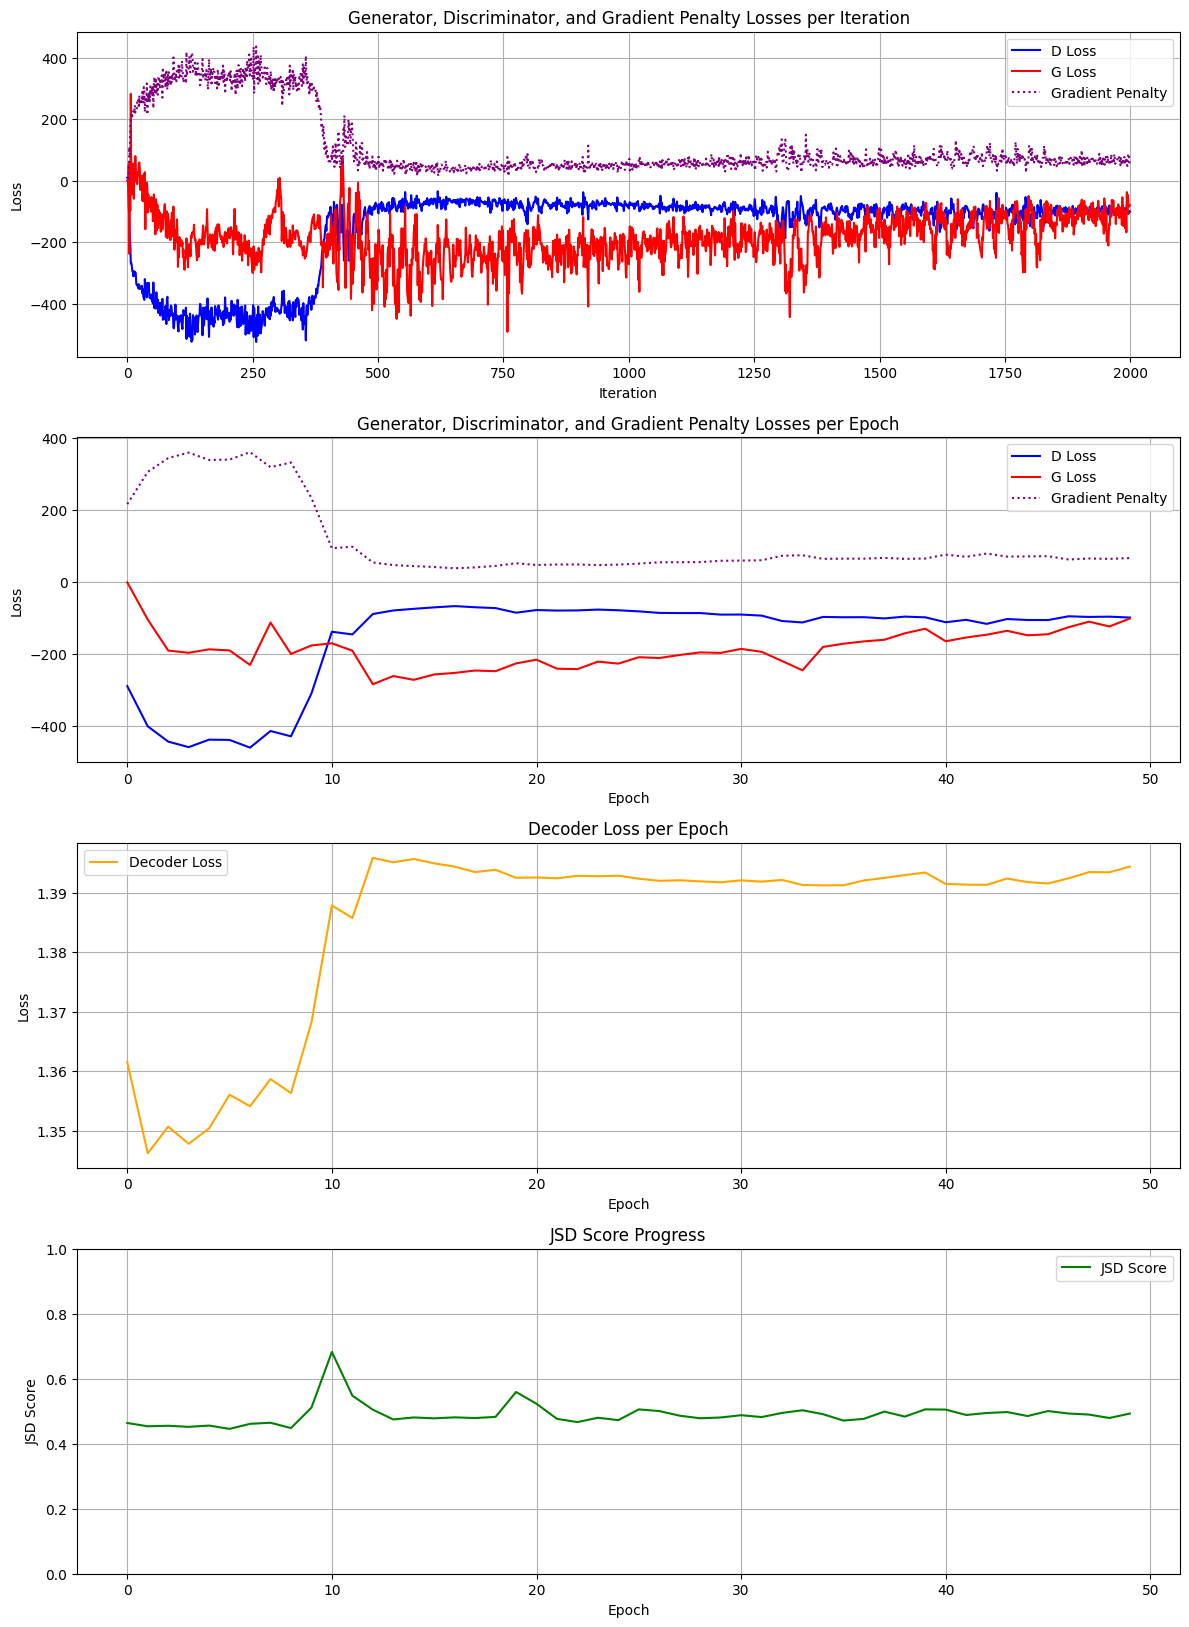

In [13]:
iteration_losses, total_iterations, jsd_history = train(generator, discriminator, dataloader, num_epochs, device=device)


plot_jsd(
    iteration_losses=iteration_losses,
    jsd_history=jsd_history,
    total_iterations=total_iterations,
    num_epochs=num_epochs,
    dataloader_size=len(dataloader)
)

In [19]:
from sequence_generator import generate_and_filter_sequences, convert_dna_fasta_to_protein

saved_model_path = r"C:\Users\kotsgeo\Documents\GANs\Old\saved_models\best_orf\generator_orf_1_epoch_49_count_28.pt"  
generator.eval()

# Generate sequences and convert to proteins in one go
sequences, analysis, dna_file = generate_and_filter_sequences(generator, num_samples=100032,add_atg=False)
num_proteins, protein_file = convert_dna_fasta_to_protein(input_fasta=dna_file, add_atg=False)

Processed 80000/100032 sequences. Found 7721 valid sequences so far.

Generation complete!
Found 9688 valid sequences out of 100032 generated
Sequences saved in: C:\Users\kotsgeo\Documents\GANs\Old\campr4\valid_sequences.fasta
Analysis saved in: C:\Users\kotsgeo\Documents\GANs\Old\campr4\sequence_analysis.txt
Converted 9688 DNA sequences to proteins
Protein sequences saved in: C:\Users\kotsgeo\Documents\GANs\Old\campr4\valid_sequences_proteins.fasta


In [21]:
from analyze_amp_probabilities import calculate_averages

# Actual usage example
files = [
    r"C:\Users\kotsgeo\Documents\GANs\Old\campr4\CAMPdownload_rf.txt",
    r"C:\Users\kotsgeo\Documents\GANs\Old\campr4\CAMPdownload_svm.txt",
    r"C:\Users\kotsgeo\Documents\GANs\Old\campr4\CAMPdownload_ann.txt"
]

model_types = [
    "Random Forest",
    "SVM",
    "ANN"
]

calculate_averages(files, model_types)

Percentage above 0.5 (Random Forest): 29.13%
Percentage above 0.8 (Random Forest): 5.99%
Percentage above 0.5 (SVM): 28.24%
Percentage above 0.8 (SVM): 6.86%
Percentage above 0.5 (ANN): 18.33%
Percentage above 0.8 (ANN): 6.41%

Averages across all models:
Average percentage above 0.5: 25.23%
Average percentage above 0.8: 6.42%
